## Global Terrorism Database (Focusing on Cyber-Related Terrorism):

This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In dividing and classifying the city names within the data-set, __[this article from the New York Times](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__ was instrumental as was __[this website](http://zakhor-online.com/?attachment_id=7932)__ and __[this one.](https://www.vox.com/a/maps-explain-the-middle-east)__
__[and this one too](http://gulf2000.columbia.edu/maps.shtml)__ https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### 1. Importing, Cleaning and General Overview:

In [144]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [145]:
# Renaming for usability:

df = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

In [146]:
# Cleaning up some of the null values in our object-type columns:
# (not dropping them but setting them to 'No Data'):

df['motive'] = df['motive'].where(df['motive'].apply(lambda x: x != 'nan'), other = 'No Data')
df['summary'] = df['summary'].where(df['summary'].apply(lambda x: x != 'nan'), other = 'No Data')

### 2. Preliminary Exploration and Visualization:

##### A. Isolating relevant data - Regex:

> Here, we want to try to isolate the rows whose summaries relate directly to what we want to analyze:

In [147]:
# Creating the dyber_df Dataframe:
# Regex to isolate qualifying data (This set is more flexible in its Regex):
import re
import gc

print(df.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

False    172205
True       9486
Name: summary, dtype: int64


In [148]:
# Creating a mask which represents the results from our search above:

mask = df.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:

cyber_df = pd.DataFrame(df[mask])

In [286]:
##### B. Looking at correlation:

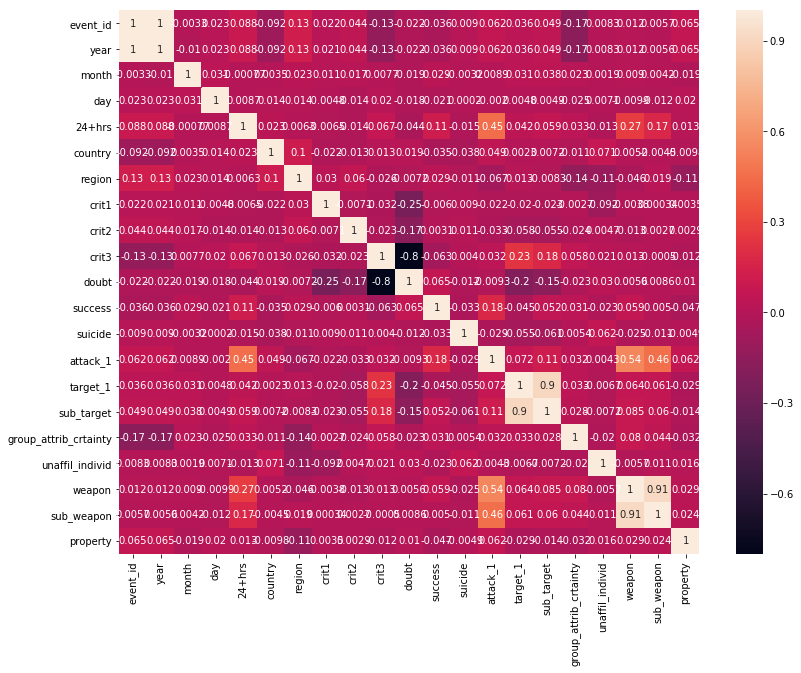

In [290]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_df.corr(), annot = True)

### 3. Data Wrangling:

> Here, I wanted to try and group some of the text columns together so as to reduce the size of potential feature-sets.  When getting dummies on some of our first models, we got too many features to provide anything explanatory.

##### Dropping inconsequential NA Values:

In [149]:
# Since making dummies of the entire dataframe didn't quite work, looking at doing some customized dummy columns
# and then using the get_dummies method for the rest:

# Running into NA issues, so dropping na where na values are under 50:

cyber_df = pd.DataFrame(cyber_df.dropna(subset = ['city', 'group_attrib_crtainty',
                                                        'specific_target']))

##### Wrangling the more considerable nulls:

In [150]:
# Taking out the NA the mean of the remaining values and 
# setting the values we did not consider with the mean of the others: 

# sub_target:

    # This method did not work, so I had to re-do it by hand:
        # sub_target_mean = cyber_df['sub_target'].mean(skipna = True)
        # cyber_df['sub_target'].fillna(sub_target_mean, inplace = True)

# Taking out the NA the mean of the remaining values:   

sub_target_actuals = cyber_df.sub_target.loc[(cyber_df['sub_target'] != np.NaN)]
sub_target_mean = sub_target_actuals.mean()
cyber_df['sub_target'] = cyber_df['sub_target'].replace(np.nan, sub_target_mean)

# sub_targettxt:
# Following the same pattern as above:

cyber_df['sub_targettxt'] = cyber_df['sub_targettxt'].replace(np.nan, 'No Data')

# victim_nationality:

cyber_df['victim_nationalitytxt'] = cyber_df['victim_nationalitytxt'].replace(np.nan, 'No Data')

# sub_weapon and sub_weapontxt:
# Filling in the NA with the mean:

sub_weapon_actuals = cyber_df['sub_weapon'].loc[(cyber_df['sub_weapon'] != np.NaN)]
sub_weapon_mean = sub_weapon_actuals.mean()
cyber_df['sub_weapon'] = cyber_df['sub_weapon'].replace(np.nan, sub_target_mean)

# Filling the NA with 'No Data'

cyber_df['sub_weapontxt'] = cyber_df['sub_weapontxt'].replace(np.nan, 'No Data')

#### Manual Dummies:

> Still a lot of unique values - will try dropping the ones with unmanageable numbers for our model. Will try grouping with the others

##### weapon and weapon_txt:

In [151]:
# Weapon:
# Grouping related values together after looking at value-counts:

# Grouping Chemical and Biological Weapons together:
cyber_df['weapon'] = cyber_df['weapon'].replace(1, 2)

# Putting Fake and 'Other' types of weapons into the same category:
cyber_df['weapon'] = cyber_df['weapon'].replace(12, 7)

# Putting vehicles into category 11 (sabotage equipment):
cyber_df['weapon'] = cyber_df['weapon'].replace(10, 11)

In [152]:
# Weapon_txt:

# Grouping Biological and Chemical Weapons:
cyber_df['weapontxt'] = cyber_df['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_df['weapontxt'] = cyber_df['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_df['weapontxt'] = cyber_df['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_df['weapontxt'] = cyber_df['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_df['weapontxt'] = cyber_df['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


###### copying df for filter-checking purposes

In [153]:
# Making a copy of the DF here to compare feature importances for modeling as well as getting a barometer for 
# the groupings we do below (i.e. to gauge how much information we are able to get or not.)

cyber_df_unfiltered = pd.DataFrame(cyber_df)

##### sub_target and sub_targettxt

In [154]:
# Sub_target:

# I didn't want to isolate all of this, else it would reflect the target column exactly - 
# but made some sub-groupings:

industrial = [1, 5, 9, 10, 12]
white_collar = [2, 3, 4, 6, 7, 8, 11, 13, 112]
gov_figure1 = [14, 18]
gov_figure2 = [15, 16, 17, 19]
police_facilities = [22, 23, 24, 26]
mil_facilities = [27, 28, 30, 31, 32, 35, 36, 39]
mil_personnel = [29, 33, 34]
pilots_planes = [42, 43]
gov_diplomatic = [45, 46, 47]
educational = [48, 49, 50]
food_water = [51, 52]
media = [53, 54, 55, 56]
religious = [69, 85, 86, 87]
political = [83, 84, 109, 110, 111]
mass_socio = [65, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]
util_telecom = [88, 89, 90, 91, 92, 106, 107, 108]

# Sub_target Assignment:

cyber_df['sub_target'].replace({'sub_target': {'industrial':1, 'white_collar':2, 
                                       'gov_figure1':14,'gov_figure2':15, 
                                       'police_facilities':22, 'mil_facilities':27,
                                       'mil_personnel':29, 'pilots_planes':42, 
                                       'gov_diplomatic':45, 'educational': 48, 
                                       'food_water':51, 'media':53, 'religious':69,
                                       'political':83, 'mass_socio': 65,
                                       'util_telecom': 88}}, inplace = True)

In [155]:
# Sub_targettxt:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in industrial), other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in white_collar), other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in gov_figure1), other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in gov_figure2), other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                                other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                                other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                                other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                                other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                                other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in educational), 
                                                other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in food_water), 
                                                other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in media), 
                                                other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                                other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in political), 
                                                other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'Train/Train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                                other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
df['sub_targettxt'] = df['sub_targettxt'].where(df['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                                other = 'Util_Telecom')

In [156]:
# Trying Group_name a bit and grouping them by Ideaology.
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_df['group_name'] = cyber_df['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_df['group_name'] = cyber_df['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_df['group_name'] = cyber_df['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [157]:
# Asian Separatists:

cyber_df['group_name'] = cyber_df['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [158]:
# Middle Eastern Separatists
cyber_df['group_name'] = cyber_df['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [159]:
# Indian Separatists
cyber_df['group_name'] = cyber_df['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [160]:
# African Political:
cyber_df['group_name'] = cyber_df['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [161]:
# Irish Separatists
cyber_df['group_name'] = cyber_df['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_df['group_name'] = cyber_df['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [162]:
# Farc left and right
cyber_df['group_name'] = cyber_df['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_df['group_name'] = cyber_df['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_df['group_name'] = cyber_df['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_df['group_name'] = cyber_df['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [163]:
# Middle Eastern Religious:
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [164]:
# Israeli, Palestinian, Lebanese Religious:
cyber_df['group_name'] = cyber_df['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [165]:
# Asian and African Religious:

cyber_df['group_name'] = cyber_df['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_df['group_name'] = cyber_df['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_df['group_name'] = cyber_df['group_name'].replace('Boko Haram',
                                                        'African_Religious')


In [166]:
cyber_df['group_name'].value_counts()

Unknown                                                                     5266
Middle_Eastern_Religious                                                    1340
Communist Party of India - Maoist (CPI-Maoist)                               400
Maoists                                                                      231
Middle_Eastern_Separatists                                                   199
Indian_Separatists                                                           166
African_Religious                                                            132
Asian_Separatists                                                            126
FARC_Leftist                                                                 125
New People's Army (NPA)                                                      111
National Socialist Council of Nagaland-Khaplang (NSCN-K)                      57
Informal Anarchist Federation                                                 45
Militant_Gunmen_Groups      

In [167]:
# Trying City Names by Religion, Tribal Associations or Conflict Areas:

sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [168]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [169]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [170]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [171]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [172]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [173]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [174]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [175]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_df['city'] = cyber_df['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


In [176]:
cyber_df['city'].value_counts()

Sunni_Shia_Split          872
Sunni_Cities              497
Unknown                   483
Makhachkala               174
Baqubah                   129
Shia_Cities                96
Kabul                      80
Karachi                    76
Mogadishu                  75
Athens                     67
Tuz Khormato               50
Abu Ghraib                 49
Peshawar                   47
Imphal                     39
Quetta                     36
Sanaa                      33
Tuz Khormato district      32
Tarmiyah                   30
Muslim_West_Africa         29
Azim                       27
Tarin Kot                  23
Muqdadiyah                 23
Baiji                      23
Dhaka                      22
Taji                       21
Dimapur                    21
Benghazi                   20
Jalalabad                  20
Bara                       19
Belfast                    18
                         ... 
Sudhakanda                  1
Naw Bahar district          1
Malanjkhan

### 4. Preliminary Models:

> Starting with some models that will help us determine feature importance (Select K-Best and Random Forest).  Also running some pca on our copied frame in case our filtering immediately above didn't work.

#### A. Select K-Best:

In [184]:
import sklearn.feature_selection

In [262]:
# A fair amount of na in corp1 (1402) and nperps (1316), so dropping the na data there:
cyber_df = pd.DataFrame(cyber_df.drop(['corp1', 'nperps'], axis = 1))


In [276]:
# Using our filtered DF:

# Defining our X and Y's: 

X = pd.get_dummies(cyber_df.drop(labels = ['event_id', 'success', 'summary', 'motive'], axis = 1))
Y = cyber_df['success']

# Fitting it to our Features and output:

KBest_1 = skl.feature_selection.SelectKBest(k = 30)
SKB_1 = KBest_1.fit(X, Y)

# Finding the indices of our selected features and putting them into a df:

feature_mask = SKB_1.get_support(indices = True)
SKB_1_features = pd.DataFrame(X.columns[feature_mask])
SKB_1_df = X.iloc[:, feature_mask]

In [284]:
# Using our unfiltered DF:

cyber_df_unfiltered.dropna(axis = 0, how = 'any')

X2 = pd.get_dummies(cyber_df_unfiltered.drop(labels = ['event_id', 'success',
                                                      'summary', 'corp1', 'motive', 'nperps'],
                                                       axis = 1))
Y2 = cyber_df_unfiltered['success']

# Fitting

KBest_2 = skl.feature_selection.SelectKBest(k = 30)
SKB_2 = KBest_2.fit(X2, Y2)

# Creating a selected DF:
feature_mask_2 = SKB_2.get_support(indices = True)
SKB_2_df = X2.iloc[:, feature_mask_2]

In [285]:
SKB_2_df

,24+hrs,doubt,attack_1,country_txt_Ireland,region_txt_Western Europe,region_2_Dublin,city_Aguada,city_Dublin,attack_1txt_Armed Assault,attack_1txt_Assassination,attack_1txt_Hostage Taking (Kidnapping),target_1txt_Military,target_1txt_Transportation,target_1txt_Unknown,"sub_targettxt_Government Personnel (excluding police, military)",sub_targettxt_No Data,sub_targettxt_Unnamed Civilian/Unspecified,specific_target_Internet Providers,specific_target_Students and staff at Cung Kiem Elementary-Junior Secondary School in Dak Lak Province in Vietnam.,specific_target_Unknown,victim_nationalitytxt_Ireland,victim_nationalitytxt_No Data,group_name_Armed Commandos of Liberation,group_name_Unknown,weapontxt_Bio-Chem,weapontxt_Explosives,sub_weapontxt_Letter Bomb,sub_weapontxt_Other Explosive Type,sub_weapontxt_Pipe Bomb,sub_weapontxt_Unknown Gun Type
11,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
74,1,0.0,6,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157,0,1.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
158,0,1.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
197,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
205,1,0.0,6,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
210,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
218,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


Both are relatively similar.

#### B. Principle Component Analysis:

> Going ahead with our cyber_df since it is larger.

In [293]:
from sklearn.decomposition import PCA

# Using the whole dataset:

PCA_1 = PCA(n_components = 30)
PCA_1.fit(X, Y)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [297]:
PCA_1.explained_variance_

array([7.54e+03, 9.01e+02, 1.21e+02, 7.77e+01, 2.71e+01, 1.27e+01,
       1.18e+01, 7.21e+00, 5.63e+00, 2.62e+00, 9.72e-01, 4.41e-01,
       3.68e-01, 3.00e-01, 2.72e-01, 2.63e-01, 2.30e-01, 1.95e-01,
       1.75e-01, 1.70e-01, 1.59e-01, 1.31e-01, 1.28e-01, 1.18e-01,
       1.11e-01, 9.53e-02, 8.87e-02, 8.20e-02, 7.93e-02, 7.06e-02])

In [309]:
PCA_1_df = pd.DataFrame(PCA_1.components_, columns = X.columns)

In [313]:
# Now looking at group_name stuffs:

In [323]:
Xnames = pd.get_dummies(cyber_df['group_name'])
Ynames = cyber_df['success']

PCA_names = PCA(n_components = 30)
PCA_names.fit(Xnames, Ynames)

PCA_names_df = pd.DataFrame(PCA_names.components_, columns = Xnames.columns)
PCA_names.explained_variance_
PCA_names_df.shape

(30, 417)

Groupnames:
http://www.start.umd.edu/baad/database

Asian Conflicts:
http://www.satp.org/conflict-maps/bangladesh



Middle East Conflicts:
http://gulf2000.columbia.edu/maps.shtml
    west africa map: http://gulf2000.columbia.edu/images/maps/West_Africa_Religion_lg.png
    libya maphttp://gulf2000.columbia.edu/images/maps/Libya_Religion_Western_Sector_lg.png
    http://gulf2000.columbia.edu/images/maps/ShiasReligionCore_lg.png
    
    
Columbia Maps:
https://www.crisisgroup.org/
    https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8
    https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/68-missing-peace-colombias-new-government-and-last-guerrillas#map-6189-1